# Домашняя работа: "Методы оптимизации"

ФИО: Фадеев Роман Андреевич

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 10 октября.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

C:\dev\miniconda\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Часть 1: Реализация методов

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

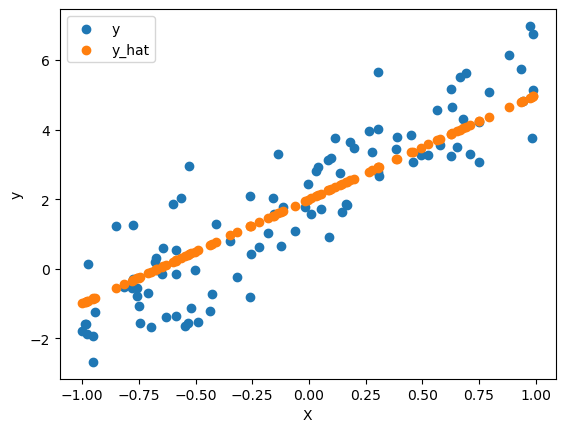

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y')
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

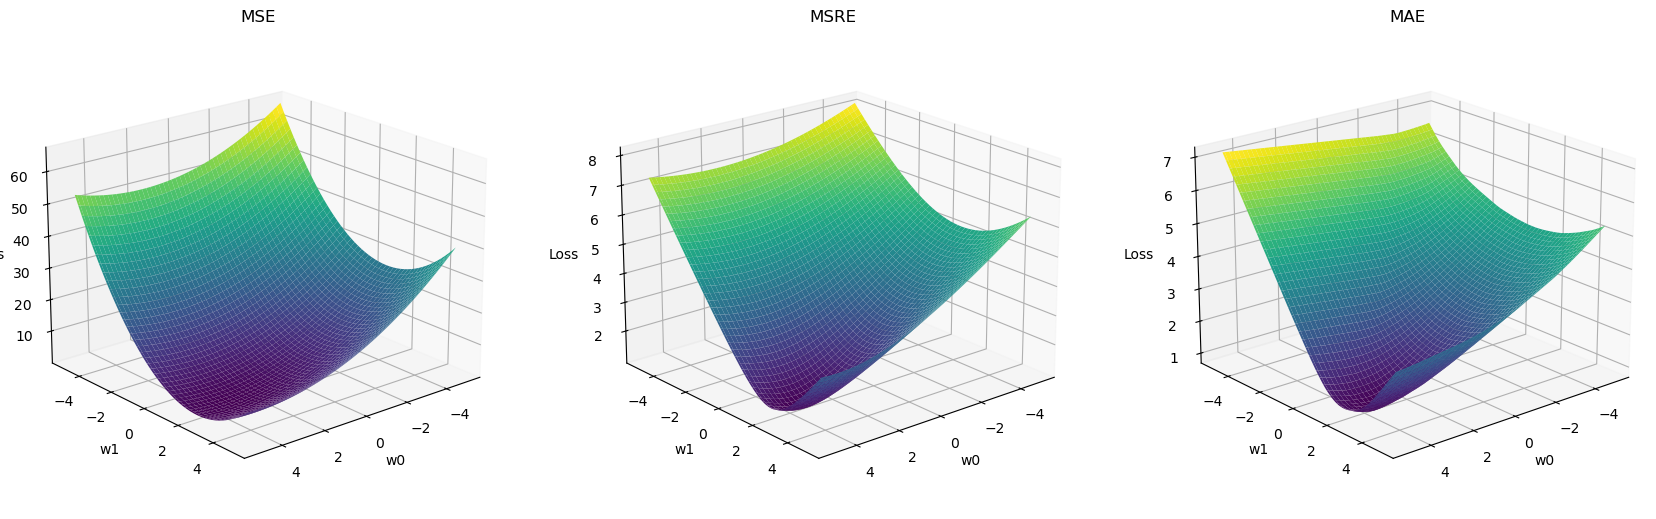

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for _ in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [9]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
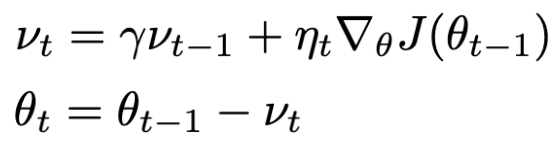

In [10]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        
        self.lr = lr
        self.gamma = gamma
        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                # Считаем, что v[i] - момент на прошлом шаге, который мы обновляем с новой итерацией.
                self.v[i] = self.gamma * self.v[i] + self.lr * p.grad
                
                p -= self.v[i]

#### AdaDelta
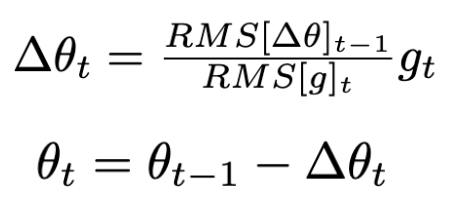

In [11]:
class AdaDelta(Optimizer):
    def __init__(self, params, eta=1e-8, gamma=0.9, base=0):
        super().__init__(params)
        
        self.eta = eta
        self.gamma = gamma
        
        self.rms_grad = [torch.zeros_like(p) for p in self.params]
        self.rms_delta = [torch.full_like(p, base) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.rms_grad[i] = self.gamma * self.rms_grad[i] + (1 - self.gamma) * p.grad ** 2

                delta = - torch.sqrt(self.rms_delta[i] + self.eta) / torch.sqrt(self.rms_grad[i] + self.eta) * p.grad

                self.rms_delta[i] = self.gamma * self.rms_delta[i] + (1 - self.gamma) * delta ** 2

                p += delta

                

#### Adam
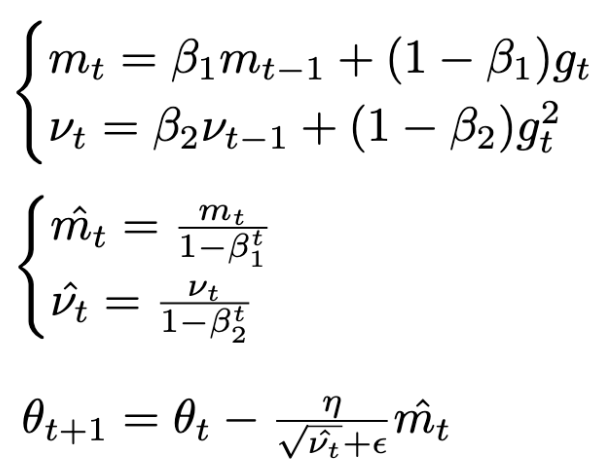

In [12]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-2, eta=1e-8, b1=0.9, b2=0.9, t=0):
        super().__init__(params)
        
        self.lr = lr
        self.eta = eta
        self.b1 = b1
        self.b2 = b2
        self.t = t

        self.momentum_m = [torch.zeros_like(p) for p in self.params]
        self.momentum_v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.t += 1

                self.momentum_m[i] = self.b1 * self.momentum_m[i] + (1 - self.b1) * p.grad
                self.momentum_v[i] = self.b2 * self.momentum_v[i] + (1 - self.b2) * p.grad ** 2

                m = self.momentum_m[i] / (1 - self.b1 ** self.t)
                v = self.momentum_v[i] / (1 - self.b2 ** self.t)

                p -= self.lr / (torch.sqrt(v) + self.eta) * m

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [13]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [14]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {}],
        ['Momentum', Momentum, {}],
        ['AdaGrad', AdaGrad, {}],
        ['AdaDelta', AdaDelta, {}],
        ['Adam', AdaDelta, {}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [15]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [16]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)

        return F.log_softmax(x, dim=1)

In [18]:
optimizers_classes = [
    SGD,
    Momentum,
    AdaGrad,
    AdaDelta,
    Adam
]

optimizer_params = [
    {},
    {'lr': 1e-3},
    {'epsilon': 1e-10, 'eta': 1e-2},
    {'gamma': 0.9, 'eta': 1e-6, 'base': 0},
    {},
]

Запустите обучение, постройте график лоссов от эпохи:

In [19]:
losses_all_optimizers = {}

for optimizer_class in optimizers_classes:
    losses = []
    network = Net()
    optimizer = optimizer_class(network.parameters())
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print('Optimizer {} - Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                optimizer_class.__name__, 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
    
    losses_all_optimizers[optimizer_class.__name__] = losses

Optimizer SGD - Train Epoch: 1 [0/60000 (0%)]	Loss: 2.519589
Optimizer SGD - Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.069757
Optimizer SGD - Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.073847
Optimizer SGD - Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.096680
Optimizer Momentum - Train Epoch: 1 [0/60000 (0%)]	Loss: 2.532292
Optimizer Momentum - Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.016349
Optimizer Momentum - Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.000754
Optimizer Momentum - Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.001654
Optimizer AdaGrad - Train Epoch: 1 [0/60000 (0%)]	Loss: 2.500462
Optimizer AdaGrad - Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.266974
Optimizer AdaGrad - Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.294964
Optimizer AdaGrad - Train Epoch: 1 [48000/60000 (80%)]	Loss: 2.328093
Optimizer AdaDelta - Train Epoch: 1 [0/60000 (0%)]	Loss: 2.443998
Optimizer AdaDelta - Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.009834
Optimizer AdaDelta - Train Epoch: 1 [32000/60000 (

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

In [20]:
class MNISTModel:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        self.device = torch.device('cpu')
    
    def create_plot(self):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_epochs, label='Train')
        plt.plot(self.val_loss_epochs, label='Val')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracy_epochs, label='Train accuracy')
        plt.plot(self.val_accuracy_epochs, label='Val accuracy')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Accuracy', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()
    
    def train_model(self, train_loader, val_loader, num_epochs=10, plot=True):
        try:
            self.train_loss_epochs = []
            self.val_loss_epochs = []
            self.train_accuracy_epochs = []
            self.val_accuracy_epochs = []
            
            for epoch in tqdm(range(num_epochs)):
                running_loss = 0.0
                correct = 0
                total = 0
                
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    self.optimizer.zero_grad()
                    
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    
                    loss.backward()
                    self.optimizer.step()
                    
                    running_loss += loss.item()
                    predicted = torch.argmax(outputs, dim=1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
                
                train_loss = running_loss / len(train_loader)
                train_acc = correct / total
                
                val_loss, val_acc = self.evaluate_model(val_loader)

                self.train_loss_epochs.append(train_loss)
                self.train_accuracy_epochs.append(train_acc)

                self.val_loss_epochs.append(val_loss)
                self.val_accuracy_epochs.append(val_acc)
                
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
                    f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
                
            if plot:
                self.create_plot()

        except KeyboardInterrupt:
            print("Interrupted")

            pass

    def evaluate_model(self, loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        loss = running_loss / len(loader)
        accuracy = correct / total

        return loss, accuracy

Using: SGD


 20%|█████████████████                                                                    | 1/5 [03:05<12:21, 185.27s/it]

Epoch [1/5], Loss: 0.1474, Accuracy: 0.9580, Val Loss: 0.0398, Val Accuracy: 0.9869


 40%|██████████████████████████████████                                                   | 2/5 [06:11<09:17, 185.98s/it]

Epoch [2/5], Loss: 0.0408, Accuracy: 0.9873, Val Loss: 0.0399, Val Accuracy: 0.9866


 60%|███████████████████████████████████████████████████                                  | 3/5 [09:18<06:12, 186.35s/it]

Epoch [3/5], Loss: 0.0233, Accuracy: 0.9926, Val Loss: 0.0335, Val Accuracy: 0.9895


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [12:12<03:01, 181.48s/it]

Epoch [4/5], Loss: 0.0134, Accuracy: 0.9956, Val Loss: 0.0309, Val Accuracy: 0.9890


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [14:53<00:00, 178.61s/it]

Epoch [5/5], Loss: 0.0084, Accuracy: 0.9976, Val Loss: 0.0228, Val Accuracy: 0.9926


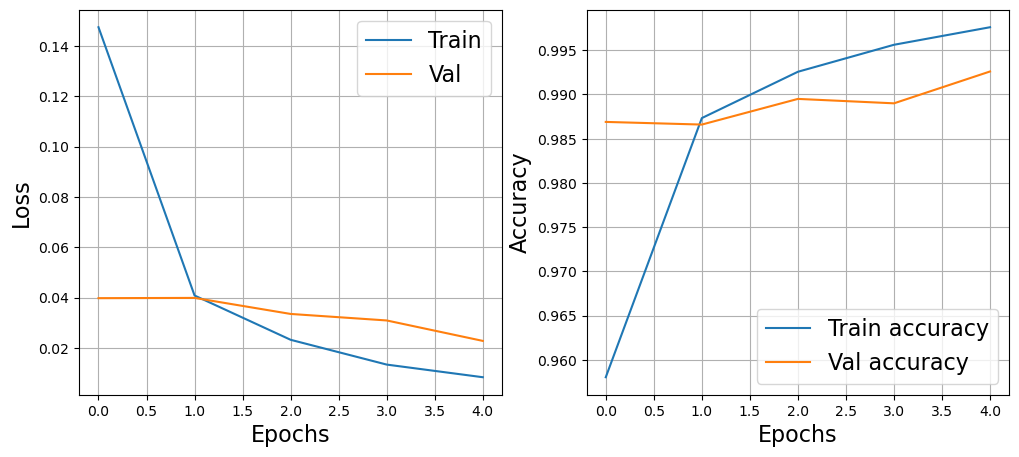

Using: Momentum


 20%|█████████████████                                                                    | 1/5 [03:00<12:03, 180.88s/it]

Epoch [1/5], Loss: 0.1531, Accuracy: 0.9563, Val Loss: 0.0378, Val Accuracy: 0.9871


 40%|██████████████████████████████████                                                   | 2/5 [05:58<08:56, 178.98s/it]

Epoch [2/5], Loss: 0.0374, Accuracy: 0.9882, Val Loss: 0.0354, Val Accuracy: 0.9891


 60%|███████████████████████████████████████████████████                                  | 3/5 [09:05<06:05, 182.77s/it]

Epoch [3/5], Loss: 0.0205, Accuracy: 0.9936, Val Loss: 0.0287, Val Accuracy: 0.9916


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [12:03<03:00, 180.62s/it]

Epoch [4/5], Loss: 0.0124, Accuracy: 0.9960, Val Loss: 0.0401, Val Accuracy: 0.9878


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [15:12<00:00, 182.58s/it]

Epoch [5/5], Loss: 0.0078, Accuracy: 0.9978, Val Loss: 0.0306, Val Accuracy: 0.9914


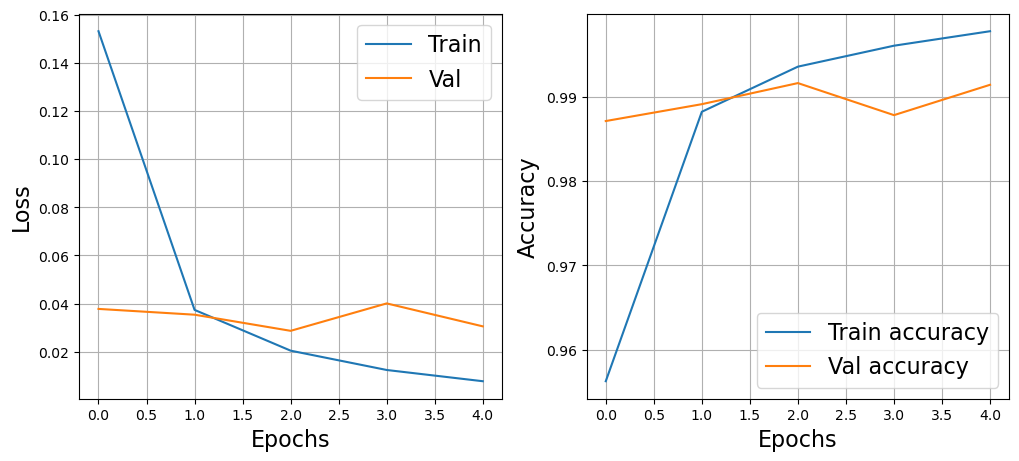

Using: AdaGrad


 20%|█████████████████                                                                    | 1/5 [03:11<12:45, 191.35s/it]

Epoch [1/5], Loss: 0.0991, Accuracy: 0.9704, Val Loss: 0.0339, Val Accuracy: 0.9892


 40%|██████████████████████████████████                                                   | 2/5 [06:06<09:06, 182.07s/it]

Epoch [2/5], Loss: 0.0258, Accuracy: 0.9920, Val Loss: 0.0278, Val Accuracy: 0.9912


 60%|███████████████████████████████████████████████████                                  | 3/5 [09:15<06:10, 185.19s/it]

Epoch [3/5], Loss: 0.0137, Accuracy: 0.9957, Val Loss: 0.0295, Val Accuracy: 0.9903


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [12:15<03:03, 183.01s/it]

Epoch [4/5], Loss: 0.0074, Accuracy: 0.9976, Val Loss: 0.0251, Val Accuracy: 0.9928


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [15:13<00:00, 182.68s/it]

Epoch [5/5], Loss: 0.0041, Accuracy: 0.9987, Val Loss: 0.0236, Val Accuracy: 0.9932


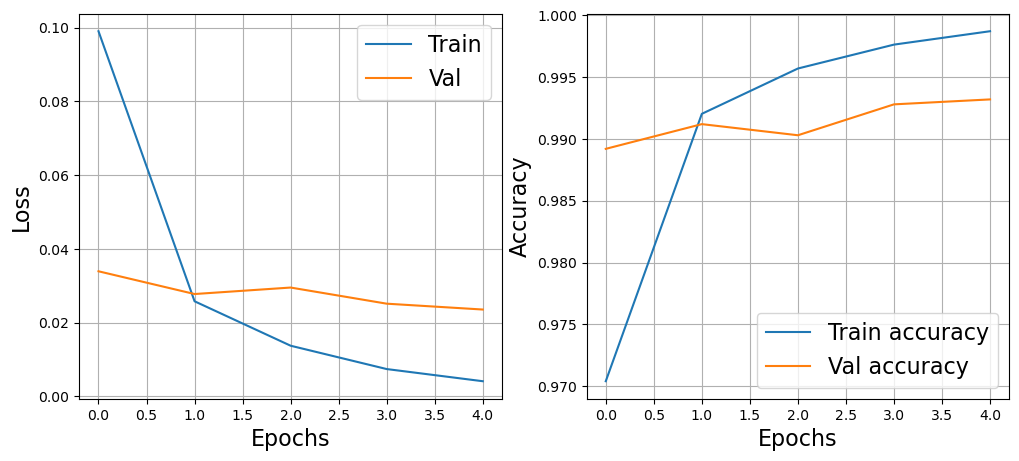

Using: AdaDelta


 20%|█████████████████                                                                    | 1/5 [03:27<13:49, 207.40s/it]

Epoch [1/5], Loss: 0.1180, Accuracy: 0.9671, Val Loss: 0.0515, Val Accuracy: 0.9857


 40%|██████████████████████████████████                                                   | 2/5 [06:45<10:05, 201.84s/it]

Epoch [2/5], Loss: 0.0467, Accuracy: 0.9874, Val Loss: 0.0276, Val Accuracy: 0.9928


 60%|███████████████████████████████████████████████████                                  | 3/5 [10:03<06:40, 200.19s/it]

Epoch [3/5], Loss: 0.0325, Accuracy: 0.9917, Val Loss: 0.0312, Val Accuracy: 0.9912


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [13:12<03:15, 195.80s/it]

Epoch [4/5], Loss: 0.0227, Accuracy: 0.9937, Val Loss: 0.0326, Val Accuracy: 0.9898


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [16:34<00:00, 198.87s/it]

Epoch [5/5], Loss: 0.0161, Accuracy: 0.9959, Val Loss: 0.0299, Val Accuracy: 0.9917


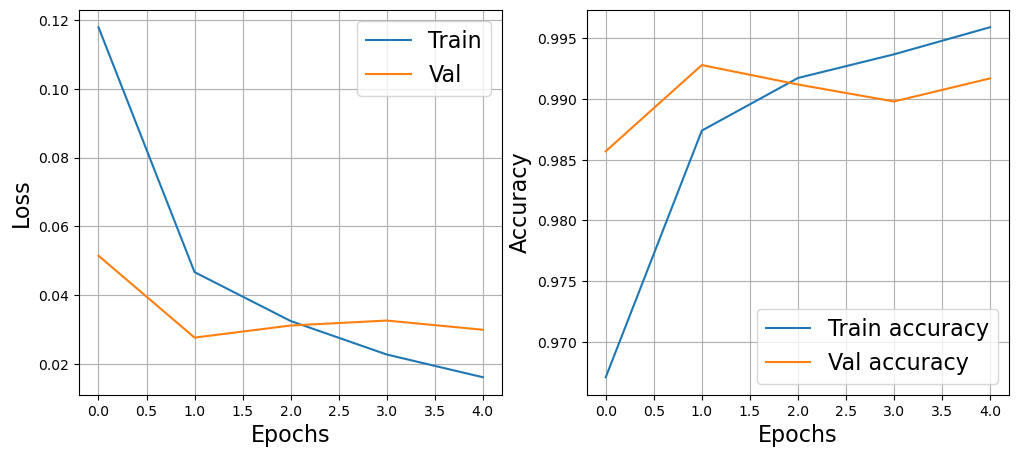

Using: Adam


 20%|█████████████████                                                                    | 1/5 [04:00<16:00, 240.13s/it]

Epoch [1/5], Loss: 0.2788, Accuracy: 0.9403, Val Loss: 0.1474, Val Accuracy: 0.9742


 40%|██████████████████████████████████                                                   | 2/5 [09:52<15:17, 305.95s/it]

Epoch [2/5], Loss: 0.1514, Accuracy: 0.9730, Val Loss: 0.0794, Val Accuracy: 0.9794


 60%|███████████████████████████████████████████████████                                  | 3/5 [16:23<11:29, 344.75s/it]

Epoch [3/5], Loss: 0.1401, Accuracy: 0.9787, Val Loss: 0.2345, Val Accuracy: 0.9749


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [23:29<06:17, 377.13s/it]

Epoch [4/5], Loss: 0.1268, Accuracy: 0.9803, Val Loss: 0.1241, Val Accuracy: 0.9820


100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [33:14<00:00, 398.98s/it]

Epoch [5/5], Loss: 0.2568, Accuracy: 0.9796, Val Loss: 0.3768, Val Accuracy: 0.9815


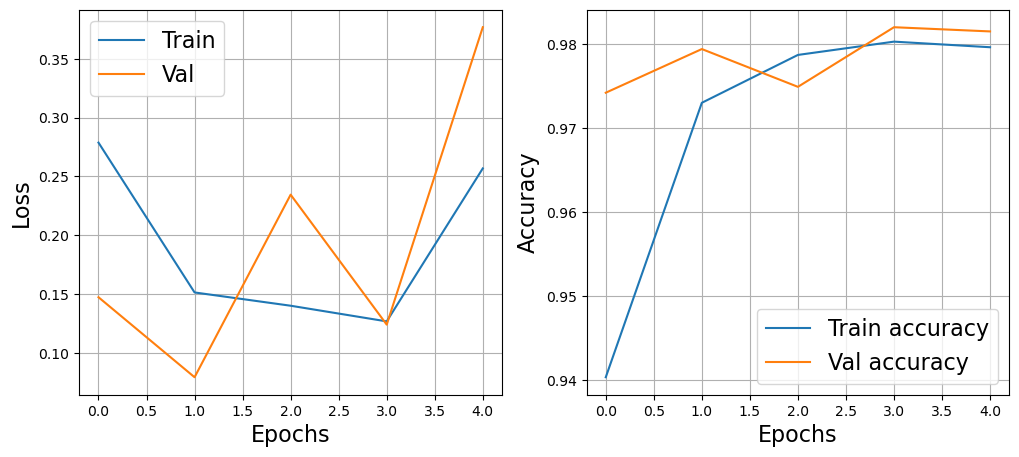

In [21]:
for i, optimizer_class in enumerate(optimizers_classes):
    network = Net()
    optimizer = optimizer_class(network.parameters(), **optimizer_params[i])
    criterion = torch.nn.CrossEntropyLoss()
    model = MNISTModel(network, criterion, optimizer)

    print(f"Using: {optimizer_class.__name__}")

    model.train_model(train_loader, test_loader, num_epochs=5)

### Сравнение графиков и выводы

- SGD имеет слабо отличающийся от других подходов результат, однако изменение градиента может быть слишком резким, что может привести к долгому схождению;
- Momentum во многом аналогичен SGD, однако видно, что его изменения более плавные вследствие сохранения инерции;
- AdaGrad имеет лучший результат, однако результат может быть слишком замедлен из-за уменьшения learning rate;
- AdaDelta имеет второй по accuracy результат, быстро сходится, имеет возможность преодолевать локальные минимумы, нет зависимости от learning rate;
- Adam кажется достаточно стабильным подходит для стабильного обучения на большом количестве эпох;